Start Amazon Sagemaker instance and choose **conda_tensorflow_p36** environment

In [ ]:
!python3 -m pip install gensim==3.8.0

# GOAL:
we want to check the similarity of words on a semantic level. Like Germany and France, both are Countries and they are close together.

We will use pre trained word embeddings that are available by Google News for example (it was trained on 100.000.000.000 words).

## Text Similarity using Word Embeddings

In this notebook we're going to play around with pre build word embeddings and do some fun calculations:

In [2]:
%matplotlib inline

import os
from keras.utils import get_file
import gensim
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(10, 10)

from sklearn.manifold import TSNE
import json
from collections import Counter
from itertools import chain

Using TensorFlow backend.


We'll start by downloading a pretrained model from Google News. We're using `zcat` to unzip the file, so you need to make sure you have that installed or replace it by something else.

In [3]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path = get_file(MODEL + '.gz', 'https://deeplearning4jblob.blob.core.windows.net/resources/wordvectors/%s.gz' % MODEL)
if not os.path.isdir('generated'):
    os.mkdir('generated')

1647050752/1647046227 [==============================] - 934s 1us/step


In [5]:
unzipped = os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'],
                          stdin=open(path),
                          stdout=fout
                         )
        zcat.wait()

### Now we use gensim ( Python topic modelling package )

https://radimrehurek.com/gensim/index.html

In [6]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

Let's take this model for a spin by looking at what things are most similar to espresso. As expected, coffee like items show up:

In [10]:
model.most_similar(positive=['cat'])

[('cats', 0.8099379539489746),
 ('dog', 0.7609456777572632),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326233983039856),
 ('beagle', 0.7150583267211914),
 ('puppy', 0.7075453996658325),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931377410889),
 ('chihuahua', 0.6709762215614319)]

Now for the famous equation, what is like woman if king is like man? We create a quick method to these calculations here:

In [11]:
def A_is_to_B_as_C_is_to(a, b, c, topn=1):
    a, b, c = map(lambda x:x if type(x) == list else [x], (a, b, c))
    res = model.most_similar(positive=b + c, negative=a, topn=topn)
    if len(res):
        if topn == 1:
            return res[0][0]
        return [x[0] for x in res]
    return None

A_is_to_B_as_C_is_to('man', 'woman', 'king')

'queen'

We can use this equation to acurately predict the capitals of countries by looking at what has the same relationship as Berlin has to Germany for selected countries:

In [12]:
for country in 'Italy', 'France', 'India', 'China':
    print('%s is the capital of %s' % 
          (A_is_to_B_as_C_is_to('Germany', 'Berlin', country), country))

Rome is the capital of Italy
Paris is the capital of France
Delhi is the capital of India
Beijing is the capital of China


Or we can do the same for important products for given companies. Here we seed the products equation with two products, the iPhone for Apple and Starbucks_coffee for Starbucks. Note that numbers are replaced by # in the embedding model:

In [16]:
for company in 'Google', 'IBM', 'Boeing', 'Microsoft', 'VW':
    products = A_is_to_B_as_C_is_to(
        ['Starbucks', 'Apple'], 
        ['Starbucks_coffee', 'iPhone'], 
        company, topn=3)
    print('%s -> %s' % 
          (company, ', '.join(products)))

Google -> personalized_homepage, app, Gmail
IBM -> DB2, WebSphere_Portal, Tamino_XML_Server
Boeing -> Dreamliner, airframe, aircraft
Microsoft -> Windows_Mobile, SyncMate, Windows
VW -> Dacia_Logan, Volkswagen, roadster


Let's do some clustering by picking three categories of items, drinks, countries and sports:

In [17]:
beverages = ['espresso', 'beer', 'vodka', 'wine', 'cola', 'tea']
countries = ['Italy', 'Germany', 'Russia', 'France', 'USA', 'India']
sports = ['soccer', 'handball', 'hockey', 'cycling', 'basketball', 'cricket']

items = beverages + countries + sports
len(items)

18

And looking up their vectors:

In [24]:
item_vectors = [(item, model[item]) 
                    for item in items
                    if item in model]
len(item_vectors), item_vectors[0][0]

(18, 'espresso')

Now use TSNE for clustering:

In [36]:
from sklearn.preprocessing import normalize

In [41]:
vectors = np.asarray([x[1] for x in item_vectors])
lengths = np.linalg.norm(vectors, axis=1) # lengths of each vector
print(lengths)
norm_vectors = (vectors.T / lengths).T
#norm_vectors = normalize(vectors)

tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

[3.586366  3.135164  3.3712635 3.2634988 3.0897832 3.3310723 2.797517
 2.658717  2.896993  2.716706  2.4355297 2.6760032 3.0090933 3.7031436
 3.3725905 3.1958177 3.077873  3.6725526]
[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.000s...
[t-SNE] Computed neighbors for 18 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 0.581543
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 53.1430168, gradient norm = 0.1165618 (50 iterations in 0.011s)
[t-SNE] Iteration 100: error = 70.9444733, gradient norm = 0.2856881 (50 iterations in 0.009s)
[t-SNE] Iteration 150: error = 75.2068253, gradient norm = 0.1622889 (50 iterations in 0.008s)
[t-SNE] Iteration 200: error = 59.5631332, gradient norm = 0.0752792 (50 iterations in 0.009s)
[t-SNE] Iteration 250: error = 52.6577568, gradient norm = 0.0679168 (50 iterations in 0.010s)
[t-SNE] KL divergence after 250 iterations with early exaggera

And matplotlib to show the results:

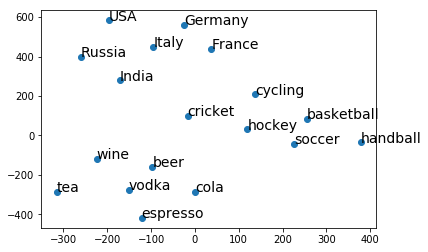

In [42]:
x=tsne[:,0]
y=tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(item_vectors, x, y):
    ax.annotate(item[0], (x1, y1), size=14)

plt.show()

As you can see, the countries, sports and drinks all form their own little clusters, with arguably cricket and India attracting each other and maybe less clear, wine and France and Italy and espresso.